<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Задача" data-toc-modified-id="Задача-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Задача</a></span></li><li><span><a href="#Данные" data-toc-modified-id="Данные-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Данные</a></span></li><li><span><a href="#Исследовательский-анализ-данных" data-toc-modified-id="Исследовательский-анализ-данных-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Исследовательский анализ данных</a></span><ul class="toc-item"><li><span><a href="#Размер-выборки" data-toc-modified-id="Размер-выборки-3.1"><span class="toc-item-num">3.1&nbsp;&nbsp;</span>Размер выборки</a></span></li><li><span><a href="#Распределение-данных" data-toc-modified-id="Распределение-данных-3.2"><span class="toc-item-num">3.2&nbsp;&nbsp;</span>Распределение данных</a></span></li><li><span><a href="#Примеры" data-toc-modified-id="Примеры-3.3"><span class="toc-item-num">3.3&nbsp;&nbsp;</span>Примеры</a></span></li><li><span><a href="#Вывод" data-toc-modified-id="Вывод-3.4"><span class="toc-item-num">3.4&nbsp;&nbsp;</span>Вывод</a></span></li></ul></li><li><span><a href="#Обучение-модели" data-toc-modified-id="Обучение-модели-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Обучение модели</a></span></li><li><span><a href="#Результаты" data-toc-modified-id="Результаты-5"><span class="toc-item-num">5&nbsp;&nbsp;</span>Результаты</a></span></li><li><span><a href="#Выводы" data-toc-modified-id="Выводы-6"><span class="toc-item-num">6&nbsp;&nbsp;</span>Выводы</a></span></li><li><span><a href="#Финальные-комментарии-ревьюера" data-toc-modified-id="Финальные-комментарии-ревьюера-7"><span class="toc-item-num">7&nbsp;&nbsp;</span>Финальные комментарии ревьюера</a></span></li></ul></div>

# Предсказание возраста по фотографии

## Задача

Сетевой супермаркет внедряет систему компьютерного зрения для обработки фотографий покупателей. Фотофиксация в прикассовой зоне поможет определять возраст клиентов, чтобы:
- анализировать покупки и предлагать товары, которые могут заинтересовать покупателей этой возрастной группы;
- контролировать добросовестность кассиров при продаже алкоголя.

Нужно построить модель, которая по фотографии определит приблизительный возраст человека.  
Пороговое значение метрики качества: MAE < 8.

## Данные

Тренировочный датасет взят с сайта [ChaLearn Looking at People](http://chalearnlap.cvc.uab.es/dataset/26/description/). 

Фотографии находятся в папке `/datasets/faces/`. 

Имеется одна папка со всеми изображениями `/final_files` и CSV-файл `labels.csv` с двумя колонками: `file_name` и `real_age`. 

Извлечь данные из папки можно с помощью [`ImageDataGenerator`](https://keras.io/preprocessing/image/) — [`flow_from_dataframe(dataframe, directory, ...)`](https://www.tensorflow.org/api_docs/python/tf/keras/preprocessing/image/ImageDataGenerator).

[Известно](http://people.ee.ethz.ch/~timofter/publications/Agustsson-FG-2017.pdf), что на этих данных можно добиться MAE = 5.4.

Цитата:

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from tensorflow.keras.optimizers import Adam
from tensorflow.keras.models import Sequential
from tensorflow.keras.applications.resnet import ResNet50
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense
from tensorflow.keras.preprocessing.image import ImageDataGenerator

2023-07-29 16:06:06.164891: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2023-07-29 16:06:06.164926: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


## Исследовательский анализ данных

Проведём исследовательский анализ данных:
- Посмотрим на размер выборки.
- Построим график распределения возраста в выборке.
- Напечатаем на экране 10–15 фотографий и посмотрим, как устроен датасет.  

Сделаем выводы о том, как результаты исследования повлияют на обучение модели.

### Размер выборки

In [37]:
try:
    labels_train = pd.read_csv('appa-real/gt_avg_train.csv')
    labels_valid = pd.read_csv('appa-real/gt_avg_valid.csv')
    labels_test = pd.read_csv('appa-real/gt_avg_test.csv')
    
    labels = pd.concat([labels_train, labels_valid, labels_test])[['file_name', 'real_age']]
    
    datagen = ImageDataGenerator(rescale=1./255)
    train_gen_flow = datagen.flow_from_dataframe(
            dataframe=labels,
            directory='appa-real/all',
            x_col='file_name',
            y_col='real_age',
            target_size=(224, 224),
            batch_size=32, 
            class_mode='raw',
            seed=12345)
    
except:
    labels = pd.read_csv('/datasets/faces/labels.csv')
    train_datagen = ImageDataGenerator(rescale=1./255)
    train_gen_flow = train_datagen.flow_from_dataframe(
            dataframe=labels,
            directory='/datasets/faces/final_files/',
            x_col='file_name',
            y_col='real_age',
            target_size=(224, 224),
            batch_size=32,
            class_mode='raw',
            seed=12345)

Found 7591 validated image filenames.


Имеется 7591 фотография.

In [35]:
labels

,file_name,real_age
0,000000.jpg,4
1,000001.jpg,18
2,000002.jpg,80
3,000003.jpg,50
4,000004.jpg,17
...,...,...
1973,007608.jpg,14
1974,007609.jpg,37
1975,007610.jpg,28
1976,007611.jpg,20


In [23]:
labels.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 7591 entries, 0 to 1977
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   file_name  7591 non-null   object
 1   real_age   7591 non-null   int64 
dtypes: int64(1), object(1)
memory usage: 177.9+ KB


В самих числах пропусков нет.

In [24]:
labels.describe()

,real_age
count,7591.000000
mean,31.201159
std,17.145060
min,1.000000
25%,20.000000
50%,29.000000
75%,41.000000
max,100.000000


Среднее выше медианы, что говорит о скошенности датасета вправо.  
Аномальных значений не наблюдается.

### Распределение данных

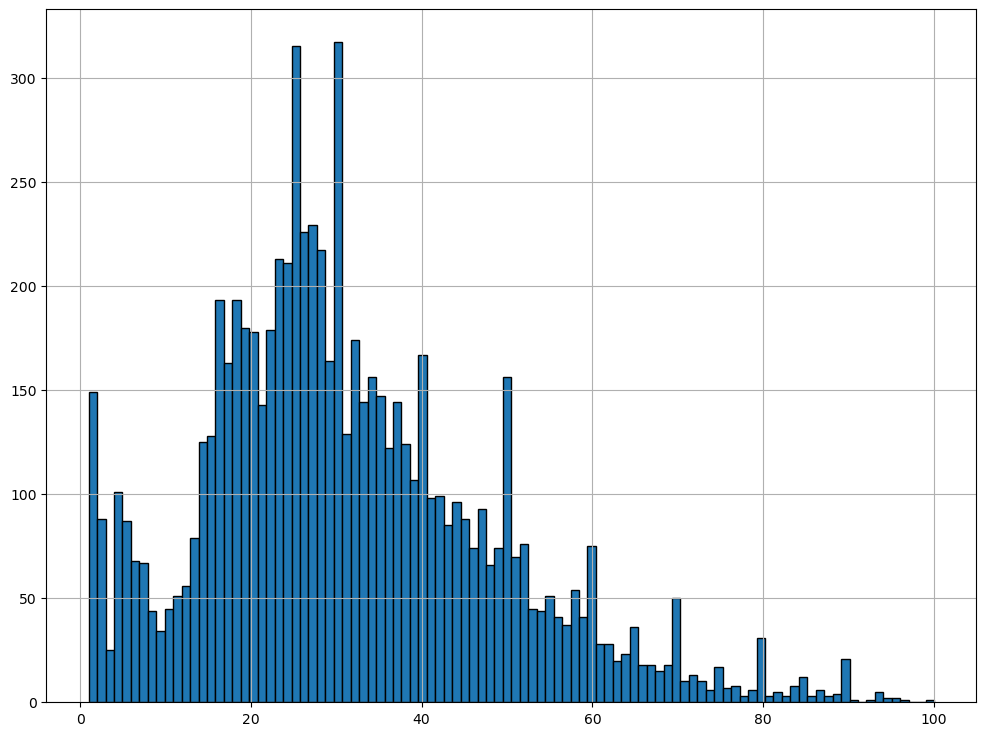

In [25]:
labels['real_age'].hist(bins=100, figsize=(12, 9), edgecolor='black')
plt.show()

In [87]:
labels['real_age'].value_counts().head()

30    317
25    315
27    229
26    226
28    217
Name: real_age, dtype: int64

Фотографий с молодыми людьми значительно больше, чем фотографий с людьми старшего или младшего возраста. 

Довольно много фотографий с младенцами. А вот для пожилых людей фотографий маловато.  
Это неудачно, всё-таки пенсионеров на кассе можно встретить чаще младенцев.

Если бы мы выделяли возрастные группы, надо было бы учесть дисбаланс классов. В задаче регрессии это вряд ли получится, хотя можно было бы добавить больше аугментаций для фотографий с людьми пожилого возраста.

Попробуем оценить количество данных по возрастным группам.

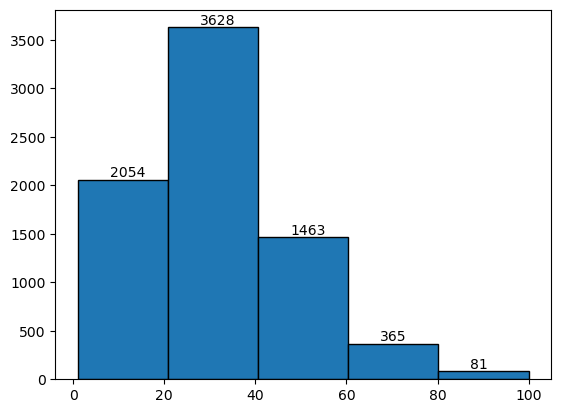

In [104]:
fig = plt.hist(labels['real_age'], bins=5, edgecolor='black')
for i in range(5):
    plt.text(fig[1][i] + 7, fig[0][i] + 30, str(int(fig[0][i])))
plt.show()

Для старших возрастных групп данных явно недостаточно. 

### Примеры

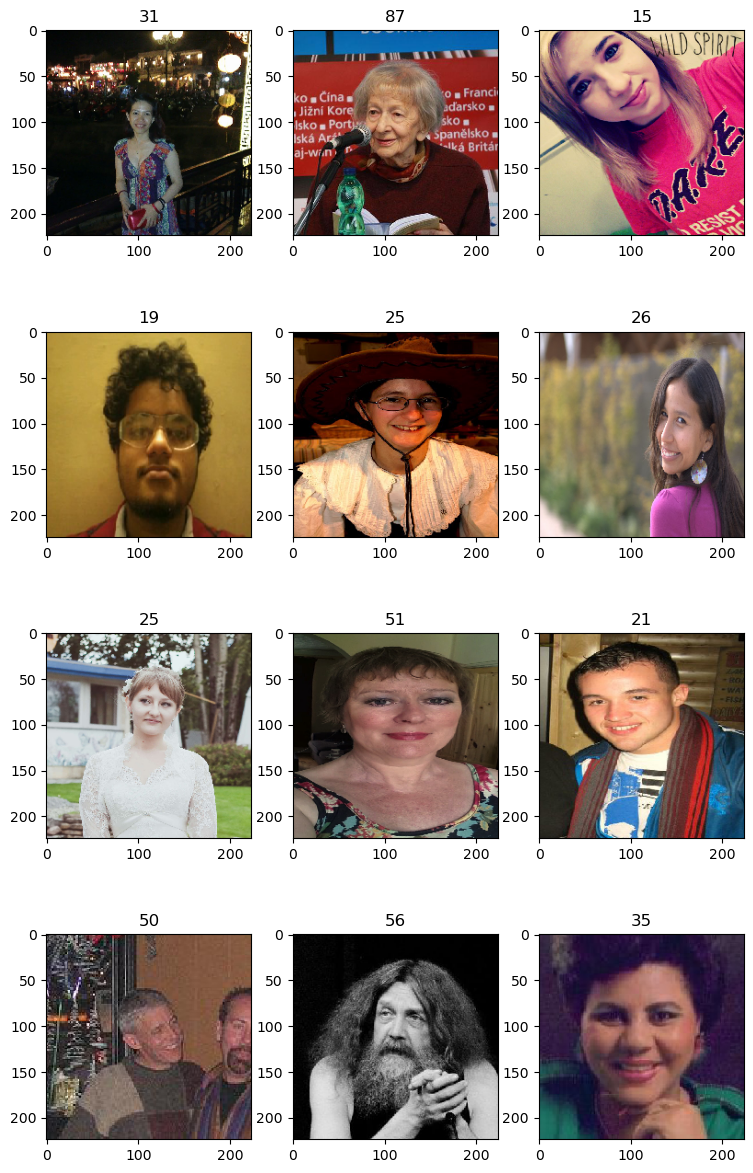

In [81]:
fig = plt.figure(figsize=(9, 15))
columns = 3
rows = 4
for i in range(1, columns * rows + 1):
    fig.add_subplot(rows, columns, i)
    plt.imshow(train_gen_flow[0][0][i - 1])
    plt.title(train_gen_flow[0][1][i - 1])
plt.show()

### Вывод

1. Обучение будет проходить на 7591 фотографии. Из них 25% придутся на валидационную выборку.
2. Большинство фотографии цветные, с 3 каналами. Все они были сжаты до размеров 224 на 224 пикселя.
3. Распределение не является нормальным, хотя напоминает его (с центром в районе 25 лет). Имеется большое количество фотографий младенцев. Ещё больше фотографий людей 25 и 30 лет. 
4. Фотографий людей пожилого возраста, наоборот, мало. Этот возрастной дисбаланс может сказаться на процедуре обучения. Если оценивать по возрастным группам, то данных достаточно.
5. Разметка фотографий выполнена корректно.

## Обучение модели

Рекомендации при обучении следующие:
- Функцией потерь не обязательно должна быть MAE. Зачастую нейронные сети с функцией потерь MSE обучаются быстрее.
- Если качество на валидационной выборке улучшается, но модель при этом переобучается всё сильнее, то модель менять не обязательно. Обычно нейронные сети с большим числом слоёв сильно переобучаются.

In [6]:
# импорты для GPU-тренажёра
'''
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from tensorflow.keras.optimizers import Adam
from tensorflow.keras.models import Sequential
from tensorflow.keras.applications.resnet import ResNet50
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense
from tensorflow.keras.preprocessing.image import ImageDataGenerator
'''

def load_train(path):
    labels = pd.read_csv(path + 'labels.csv')
    
    train_datagen = ImageDataGenerator(
        validation_split=0.25, 
        rescale=1. / 255, 
        horizontal_flip=True, 
        height_shift_range=0.2, 
        width_shift_range=0.2)
    
    train_data = train_datagen.flow_from_dataframe(
        dataframe=labels, 
        directory=path + '/final_files',
        x_col='file_name',
        y_col='real_age',
        target_size=(224, 224),
        batch_size=32, 
        subset='training', 
        class_mode='raw',
        seed=12345)
    
    return train_data


def load_test(path):
    labels = pd.read_csv(path + 'labels.csv')
    
    test_datagen = ImageDataGenerator(
        validation_split=0.25, 
        rescale=1/255.)
    
    test_data = test_datagen.flow_from_dataframe(
        dataframe=labels, 
        directory=path + '/final_files',
        x_col='file_name',
        y_col='real_age',
        target_size=(224, 224),
        batch_size=32, 
        subset='validation', 
        class_mode='raw',
        seed=12345)

    return test_data


def create_model(input_shape=(224, 224, 3)):
    backbone = ResNet50(
        input_shape=input_shape, 
        weights='/datasets/keras_models/resnet50_weights_tf_dim_ordering_tf_kernels_notop.h5', 
        include_top=False) 

    model = Sequential()
    model.add(backbone)
    model.add(GlobalAveragePooling2D())
    model.add(Dense(1, activation='relu')) 
    model.compile(loss='mse', optimizer=Adam(lr=0.0001), metrics=['mae'])
    
    return model


def train_model(model, train_data, test_data, 
                batch_size=None, epochs=5,
                steps_per_epoch=None, validation_steps=None):
    
    model.fit(train_data,
              validation_data=test_data,
              batch_size=batch_size, epochs=epochs,
              steps_per_epoch=steps_per_epoch,
              validation_steps=validation_steps,
              verbose=2)
    
    return model

В GPU-тренажёре по этим функциям был получен следующий результат:

## Результаты

Порог тестирования в MAE < 8 пройден (даже с небольшим запасом).  

С другой стороны мы видим, что модель переобучилась: валидация на тренировочной выборке даёт `MAE = 5.2295`, в то время как при тестировании модель показывает `MAE = 6.3274`.  
Это соответствует примерно третьей эпохе обучения (из пяти проведённых).

## Выводы

1. Данные представляют собой набор из 7591 цветной фотографии (и небольшого числа чёрно-белых).
2. Фотографии имеют разный размер, но для обучения они были сжаты до одинаковых размеров в 224 на 224 пикселя.
3. В данных наблюдается серьёзный возрастной дисбаланс: молодых людей (от 18 до 30) заметно больше, чем прочих возрастных групп. Также много фотографий младенцев. Если группировать данные по возрастным группам, то для обучения фотографий достаточно.
4. Для обучения была использована свёрточная сеть ResNet50, которая использовала подобранные заранее веса в качестве исходных значений.
5. При обучении использовались аугментации: отражения фотографий по горизонтали и сдвиги на 20% пикселей по вертикали и горизонтали.
6. Модель обучалась на 5 эпохах, то есть 5 раз подстраивала коэффициенты в полносвязном слое под преобразованные фотографии (функция потерь – MSE). Это привело к переобучению. Так, на первой эпохе MAE составила 11.13, а на пятой – 5.23. Ошибка на тестовой выборке составила 6.33 года, что соответствует примерно третьей эпохе обучения.
7. Оптимизация осуществлялась алгоритмом Adam со скоростью обучения, равной 0.0001. В течение каждой эпохи она осуществлялась за 178 шагов, на 60 из которых была валидация.
8. Обученная модель может определять возраст покупателей со средней погрешностью не менее 6 лет (на практике может быть и больше). В связи с этим данную модель можно использовать для анализа покупок и предложения товаров.
9. Тем не менее, для контроля добросовестности кассиров при продаже алкоголя использовать её не получится: точности не хватает. Если модель предскажет, что покупателю 16 лет, она вполне может ошибиться в меньшую стороны.